# 1. Μέρος 1ο – Ταξινόμηση με Συνελικτικά Νευρωνικά Δίκτυα (60%)
### d. Πειραματιστείτε και προτείνετε ένα CNN δικής σας έμπνευσης που να βελτιστοποιεί την ακρίβεια ταξινόμησης στο test set χωρίς ενδείξεις overfitting.

Εδω αναλύθηκε το ερώτημα δ με μία ResNet αρχιτεκτονική και βλέπουμε πως φτάνει μέχρι τα 90% ακρίβεια.

In [ ]:
import numpy as np 
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [ ]:
train_transform = transforms.Compose([
                                      transforms.RandomHorizontalFlip(p = 0.4), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(30), #Rotates the image to a specified angel
                                      transforms.Pad(4),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
test_transform = transforms.Compose([
                               transforms.Pad(4),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [ ]:
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

trainloader = DataLoader(dataset=train_data, 
                          batch_size=128,
                          num_workers=2,
                          shuffle=True)

testloader = DataLoader(dataset=test_data, 
                         batch_size=128,
                         num_workers=2,
                         shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Το πρώτο βήμα για την αρχιτεκτονική του ResNet είναι ο ορισμός του 1ου μπλοκ όπου γίνεται convolution και max pooling καθώς και batch normalisation. 
Στη συνέχεια ορίζονται τα επίπεδα ResNet μέσω της κλάσης ResNet. 
Για την "μεταπήδηση" στην έξοδο χρησιμοποιούνται shortcuts. Εδώ χρησιμοποιούμε 1x1 convolutions ώστε να έχω ίδιο μέγεθος με την έξοδο. 

In [ ]:
class BasicBlock(nn.Module):


    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

   

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [ ]:
# number of epochs
epochs = 50
# learning rate
learning_rate = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model = resnet18()

In [ ]:
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Test loss', 'Test accuracy']) 

In [ ]:
#train the model
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0

    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
       
        
    time_elapsed = time.time() - since
    test_loss = 0
    test_accuracy = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")
  
    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader)}, ignore_index=True)
    running_loss = 0
    model.train()

Epoch 1/50.. Time per epoch: 70.9783.. Average time per step: 0.1815.. Train loss: 1.6231.. Train accuracy: 0.4044.. Test loss: 1.4856.. Test accuracy: 0.4473.. 
Epoch 2/50.. Time per epoch: 67.2342.. Average time per step: 0.1720.. Train loss: 1.2628.. Train accuracy: 0.5408.. Test loss: 1.3124.. Test accuracy: 0.5359.. 
Epoch 3/50.. Time per epoch: 67.4423.. Average time per step: 0.1725.. Train loss: 1.0890.. Train accuracy: 0.6096.. Test loss: 0.9841.. Test accuracy: 0.6446.. 
Epoch 4/50.. Time per epoch: 67.1019.. Average time per step: 0.1716.. Train loss: 0.9836.. Train accuracy: 0.6510.. Test loss: 0.8835.. Test accuracy: 0.6843.. 
Epoch 5/50.. Time per epoch: 67.1574.. Average time per step: 0.1718.. Train loss: 0.8922.. Train accuracy: 0.6859.. Test loss: 0.7869.. Test accuracy: 0.7299.. 
Epoch 6/50.. Time per epoch: 67.2698.. Average time per step: 0.1720.. Train loss: 0.8147.. Train accuracy: 0.7108.. Test loss: 0.7947.. Test accuracy: 0.7211.. 
Epoch 7/50.. Time per epoch:

Παρατηρούμε, πως και το ResNet φτάνει πολύ υψηλή ακρίβεια, χωρίς overfit. Γενικά, το ResNet και το DenseNet επιλέχθηκαν καθώς λύνουν το πρόβλημα των vanishing gradients, και μπορούν να αποδώσουν καλά σε μεγάλα dataset. 

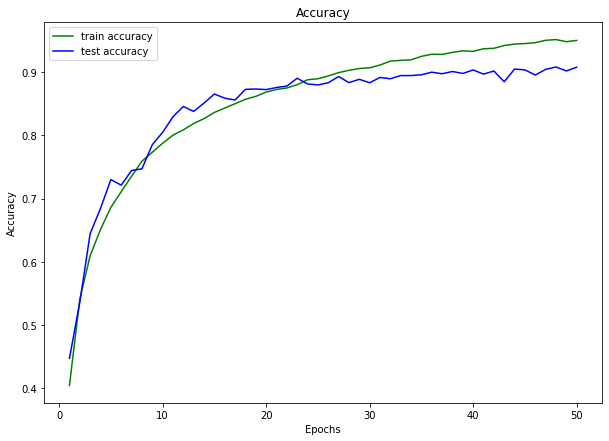

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='train accuracy');
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='test accuracy');

plt.legend()